# Investigating realistic defects in optical cavities
Yashwant Bothra, Andreas Freise, 06.01.2026

## Introduction

Optical cavities are extensively used in gravitational wave (GW) detectors. They are the building blocks of current and future GW detectors. There are multiple reasons for this, which are explained in the technical note provided and in other references.  We want to understand the consequences of using such optical systems (cavities). What if these optical cavities are not perfect? What happens *fundamentally* to the beam when things are *defective*? 

## Goals of this notebook

We will not focus on the analytical understanding of these principles here, but instead try to understand—visually and intuitively—the consequences of imperfect optics. In GW detectors, these effects are among the major sources of “noise” that affect the overall sensitivity of the detectors, and they constitute a major part of current research in gravitational-wave science.

1. In the first part of this notebook, we will study a perfect cavity, which can be thought of as a mode-matched system. We will define a way to study these cavities using **free spectral range (FSR) scans**. FSR scans can be understood as scanning the distance between the two cavity mirrors ($L$) in units of the wavelength of light.

2. The second part of this notebook will focus on:
   * Alignment errors  
   * Mode mismatch  

   We will show the scattering of light into HOMs due to these defects.

After completing this notebook, you will be able to:

* Build and simulate optical cavities in FINESSE  
* Perform FSR scans to study the behaviour of these cavities  
* Model defects in these optical systems and understand the effect of these defects  
* Build a fundamental understanding of the interaction of light with imperfect optical systems  

### What you will submit

The notebook activities are your “experiments”. The output expected from you is a short report (2000 to 4000 words) based on the results obtained in this notebook, in which you describe and interpret what you have learned. 

In the report, you should describe and discuss the physics of the simulated optical cavities: which parameters were scanned (for example, mirror tuning) to study these cavities and why; what happens in the presence of imperfections in the optics; and which higher-order modes (HOMs) can resonate inside the cavities. You should focus on the physical properties of optical cavities and how they govern the imperfections that can lead to power loss from the fundamental mode. The discussion should be guided by the free spectral range scans.

----

## Background

Laser beams can be often be described well as Gaussian beams, specifically the HG<sub>00</sub> (fundamental) mode. Ideally, we would want only the fundamental mode to be present everywhere in a GW detector. You may ask: if not HG<sub>00</sub>, then what else could appear?  

For the rest of this notebook, we will use the Hermite–Gauss (HG) basis to describe our beams. The HG<sub>00</sub> mode will represent the fundamental Gaussian mode. In addition to this, other modes in the HG basis (for example HG<sub>01</sub>, HG<sub>02</sub>, HG<sub>12</sub>, etc.) can also appear—and they do. These are commonly referred to as higher-order modes (HOMs). One of the reasons HOMs appear is that our optics have defects, are misaligned or that optical cavity are 'mode-mismatched'.

Now, in this discussion, optical cavities come into the picture. It is important to understand the concept of cavity **eigenmodes**. One can think of a cavity as a system in which the mirrors impose boundary conditions on the laser beam. These boundary conditions typically allow only one specific type of beam (i.e., one $q$-parameter) to resonate inside the cavity. This is called the eigenmode of the cavity. The eigenmode is determined by the geometry of the mirrors forming the cavity (for example, their radii of curvature). When the input beam from the laser has the same shape as the cavity eigenmode, we call the system perfectly mode-matched. If there is any mode mismatch—i.e., if the input beam no longer matches the cavity eigenmode—the laser beam shape get's distorted when entering or leaving the cavity. In our mathematical model this process is described by scattering power from the original HG<sub>00</sub> beam into HOMs. 

In a similar fashion, if the alignment of the cavity is changed—for example, if one mirror is tilted by 1 degree (just for imagination; this would be an absurdly large number in our field)—the geometry (or, more precisely, the cavity axis) is changed. This modifies the resonance condition inside the cavity and also leads to scattering of the fundamental mode into HOMs. 

All of the principles discussed above will be modeled and simulated using **FINESSE**, and we will show that these statements are indeed true.

In [ ]:
# install pypi wheel only on google colab
!env | grep -q 'colab' && pip install finesse || echo 'Not on google colab, assuming finesse already installed'

In [1]:
import finesse 
import matplotlib.pyplot as plt
import numpy as np
finesse.configure(plotting=True)
from finesse.analysis.actions import Xaxis, Maximize
from ipywidgets import interact, IntSlider

## Ideal Optical Cavities

In this section of the notebook, we will model **ideal** optical cavities with no defects. We will mainly look at **FSR scans** of these cavities. Through these scans, we will be able to better appreciate the resonance conditions inside the cavity.

For the geometry of these cavities, we adopt parameters inspired by the Advanced LIGO arm cavities. (Source: https://finesse.docs.ligo.org/finesse-ligo/parameter_files/llo.html)

In the model, we have to define the beam (the q-parameter). Since this is crucial for everything we compute (for example, mode mismatch) in our model, it is necessary to define the beam parameter properly. In FINESSE, we can do this using the **cav** or **Cavity** command: https://finesse.ifosim.org/docs/latest/usage/elements/gaussian_beams.html#kat-element-cavity.
What the cavity command does is compute the eigenmode (q<sub>cav</sub>) of the cavity (which is defined by the ITM and ETM), then trace the beam through all the nodes in the system and compute the beam parameter (q) at all nodes in the model. **Cav** command takes care of the mode matching.


In [2]:
## Modeling an ideal cavity in FINESSE
## ----------------------------------------------------
# Geometry of our cavities
L = 3994.485 # cavity length in meters 
rocITM = -1937.9 # RoC of the input test mass/mirror
rocETM = 2240.0 # RoC of the end test mass mass

# Building an optical cavity model in Finesse 
cavLIGO = finesse.Model()

# Defining the optics (lasers, mirrors, etc.)
cavLIGO.parse(
f"""
# Input optics          
l l1 P=1 #laser with 1W power
s s1 l1.p1 ITM.p1 #space between laser and input test mass

# Input test mass/mirror of the cavity
# T and L are the transmittivity and losses in the mirror
# and R (reflectivity) is computed as R=1-T-L. 
m ITM T=0.0148 L=37.5e-6 Rc={rocITM} #mirror
           
# Space between the two test masses 
s s2 ITM.p2 ETM.p1 L={L} #defined in the geometry

# End test mass 
m ETM T=7.1e-6 L=37.5e-6 Rc={rocETM} #mirror
""");

The eigenmode of the cavity is characterized by a Gaussian beam with: 
waist radius w0 = 0.01202 m, 
beam radius w = 0.06191 m, 
and waist location z = -2155.56 m.


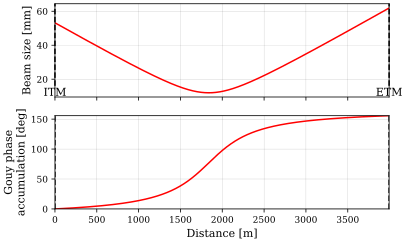

In [3]:
## Mode matching our optical cavity model 
## -----------------------------------------
# This copies everything from our model which was 
# defined in our cavLIGO model.
matched = cavLIGO.deepcopy()
matched.modes(maxtem=2) #adding HOMs to our simulations of max order 2

# Adding cavity to the model for mode matching.
# The cavity is formed by the internal nodes of the ITM and ETM.
matched.parse(f"cav arms source=ETM.p1.o via=ITM.p2.i")

# to propagate and calculate the beam parameters in all the nodes of the model
# we have to run the model as shown below.
matched.run() 

## Reading & plotting the beam parameters of our model
## -------------------------------------------
# printing the beam parameter (q) of the cavity i.e. eigenmode 
# The q-parameter will describe the beam with respect to ETM.p1.o node 
# which is used to define the source of the cavity

print(
    "The eigenmode of the cavity is characterized by a Gaussian beam with: \n"
    f"waist radius w0 = {matched.arms.qx.w0:.4g} m, \n"
    f"beam radius w = {matched.arms.qx.w:.4g} m, \n"
    f"and waist location z = {matched.arms.qx.z:.6g} m."
)

# Plotting the beam size and Gouy phase inside the cavity
matched.propagate_beam(from_node='l1.p1.o', to_node='ETM.p2.o').plot();

In [4]:
## example of computing the beam parameters in any 
## one of the nodes of our model

print(matched.l1.p1.o.qx)

# so this is the beam that should be emitted by our laser
# to have a completely mode matched system i.e. to match the 
# eigenmode of the cavity (which is fixed and unique).

BeamParam(w0=12.02 mm, z=-1.8389 km, w=53.189 mm, Rc=-1.9379 km)


### Free Spectral Range scans

The properties and the mode matching of optical cavities can be studied using **free spectral range (FSR) scans**. Even in current GW detectors, FSR scans are used to study and understand the physics of these cavities. They provide a large amount of information about the mode matching and the presence of higher-order modes (HOMs). In this section, we will look at the FSR scans of the LIGO cavities defined above. We will try to interpret these scans and understand the physical nature of the cavities and the beams resonating inside them.

To perform an FSR scan, we tune the microscopic **phi** parameter of the mirrors and sweep it over many resonances.


In [5]:
## Free spectral range (FSR) scans
## --------------------------------------------
#copying the mode matched model
fsr = matched.deepcopy() 

# adding detectors to our model to probe different Physics
fsr.parse(
    f"""
    # power detectors to measure the total power
    # circulating, transmitted, and reflected. 
    pd refl ITM.p1.o
    pd trans ETM.p2.o
    pd circ ETM.p1.i

    # amplitude detector for HOMs (inside the cavity)
    ad ad00 ETM.p1.i l1.f n=0 m=0
    ad ad01 ETM.p1.i l1.f n=0 m=1
    ad ad10 ETM.p1.i l1.f n=1 m=0
"""
)

## studying model mismatches
print(fsr.mismatches_table())

## This prints an empty table indicating no mismatches 
## in the cavities.

# A sweep from 0 to 360 degrees corresponds to a cavity length change of one wavelength (λ),
# i.e. two cavity resonances (since resonances occur every λ/2).
scan = fsr.run(Xaxis('ETM.phi', 'lin', -200, 200, 500))

┌──────────╥──────────────┬──────────────┐
│ Coupling ║ Mismatch (x) │ Mismatch (y) │
└──────────╨──────────────┴──────────────┘



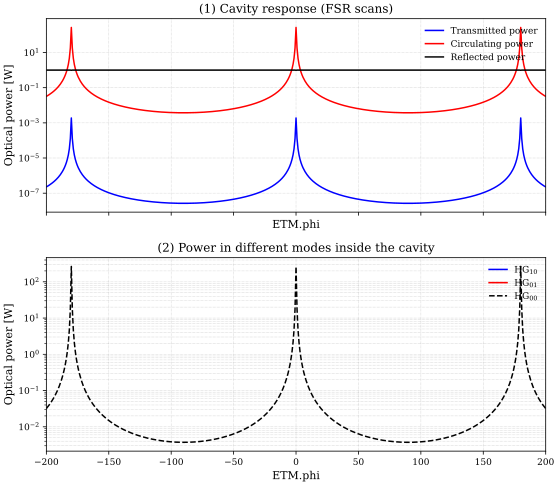

In [6]:
# FSR scan plots
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(8, 7),
)

ax = axes[0]
ax.plot(scan.x[0], scan["trans"], label="Transmitted power")
ax.plot(scan.x[0], scan["circ"],  label="Circulating power")
ax.plot(scan.x[0], scan["refl"],  label="Reflected power")
ax.set_yscale("log")
ax.set_xlabel(r"ETM.phi")
ax.set_ylabel("Optical power [W]")
ax.set_title("(1) Cavity response (FSR scans)")
ax.legend(frameon=False)
ax.grid(True, which="both", linestyle=":", linewidth=0.5)

ax = axes[1]
ax.plot(scan.x[0], np.abs(scan["ad10"])**2, label=r"HG$_{10}$")
ax.plot(scan.x[0], np.abs(scan["ad01"])**2, label=r"HG$_{01}$")
ax.plot(scan.x[0], np.abs(scan["ad00"])**2, linestyle="--",label=r"HG$_{00}$")
ax.set_yscale("log")
ax.set_xlabel(r"ETM.phi")
ax.set_ylabel("Optical power [W]")
ax.set_title("(2) Power in different modes inside the cavity")
ax.legend(frameon=False)
ax.grid(True, which="both", linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

**Task**: Look at the absolute values of the three powers and how they are related to each other. Can you explain the relationship with simple and intuitive arguments? 

The circulating power inside the cavity increases for specific values of the ETM length tuning (ETM.phi), corresponding to resonance conditions, for example at ETM.phi = 0 in the plot shown above. These (resonance) peaks correspond to the condition of perfect resonance of the laser field, i.e., when the round-trip phase accumulated by the laser beam satisfies the constructive interference condition. Under this condition, the intracavity field builds up and the circulating power reaches its maximum. At the same time, the transmitted power through the cavity is maximized, while the reflected power exhibits a minimum (a dip).

The second plot shows the absence of any higher-order modes (HOMs). This is because the optical system is ideal and free of defects and imperfections. Consequently, all the optical power is carried by the fundamental mode.

*Fun fact: In Finesse, we can measure the optical field and power at any point, whereas in a real experiment this is generally not possible. In practice, we can measure the light transmitted by the cavities. When we want to align (or tune) a cavity to its resonance condition, we often maximize the transmitted power in the fundamental mode.*

In [7]:
# One can also access all the information about the cavity defined in the model,
# in the following way. The table encompasses all the information such as
# Finesse, FWHM, stability, pole frequency, beam waist and sizes, etc.
print(fsr.arms.info())

Cavity arms

Parameters:
n/a

Information:
┌───────────────────────┬─────────────────────────────────┐
│ Description           │ Value                           │
╞═══════════════════════╪═════════════════════════════════╡
│ FSR                   │ 37525.79594115386               │
├───────────────────────┼─────────────────────────────────┤
│ Loss                  │ 0.014881438247499879            │
├───────────────────────┼─────────────────────────────────┤
│ Finesse               │ 419.0658427911947               │
├───────────────────────┼─────────────────────────────────┤
│ FWHM                  │ 89.54630062715849               │
├───────────────────────┼─────────────────────────────────┤
│ Storage time          │ 0.003554696106421291            │
├───────────────────────┼─────────────────────────────────┤
│ Pole                  │ 44.773150313579244              │
├───────────────────────┼─────────────────────────────────┤
│ Round trip length     │ 7988.97                        

## Cavity as a mode discriminator

Before we delve into the details of optical imperfections, let us first understand how a simple cavity acts as a mode discriminator. By mode discrimination, we mean the ability of a cavity to allow only a desired spatial mode to resonate while suppressing other modes. The geometry of the cavity allows only certain modes to resonate for a given tuning (ETM.phi) of the cavity. Higher-order modes (HOMs) satisfy different resonance conditions because they accumulate different Gouy phases, which depend on the mode order.

To demonstrate this effect, we intentionally introduce HOM content into the input laser beam with different amplitudes. That is, instead of a purely Gaussian beam, as in the ideal examples discussed earlier, we now inject a beam that contains a superposition of several transverse modes into the cavity. We then perform an FSR scan of this non-ideal input beam and plot the two-dimensional beam images transmitted by the cavity.

By examining the transmitted field, we can observe that different modes resonate at different tunings of the ETM. This clearly illustrates the mode-discriminating property of optical cavities.

The plot is an interactive set of beam images, so feel free to scroll through them and explore how the transverse mode content changes with ETM tuning. This will help build intuition and will later make it easier to understand the plots we will encounter in the context of mode mismatch and misalignment.

In [8]:
# Helper function to plot CCD images
def plot_ccd(ccd, idx=0, *, use_extent=False, extent=None, xlim=None, ylim=None,
             units="m", figsize=(5, 4), cmap="inferno", show_colorbar=True,
             title="CCD", zmin=None, zmax=None, autoscale=True):
    """
    Parameters
    ----------
    zmin, zmax : float or None
        Color scale limits. If both are provided -> fixed scale.
    autoscale : bool
        If True and zmin/zmax are None -> autoscale from data.
        If False and zmin/zmax are None -> use full array global limits.
    """

    ccd = np.asarray(ccd)

    if ccd.ndim == 3:
        I = ccd[idx]
        Iall = ccd
    elif ccd.ndim == 2:
        I = ccd
        Iall = ccd
    else:
        raise ValueError("ccd must be (Nscan,Ny,Nx) or (Ny,Nx) array")

    # Color scaling logic
    # ----------------------------
    if zmin is not None and zmax is not None:
        vmin, vmax = zmin, zmax
    else:
        if autoscale:
            vmin, vmax = np.nanmin(I), np.nanmax(I)
        else:
            vmin, vmax = np.nanmin(Iall), np.nanmax(Iall)

    imshow_kwargs = dict(
        origin="lower",
        aspect="equal",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )

    # Extent logic
    # ----------------------------
    if use_extent:
        if extent is None:
            if xlim is None or ylim is None:
                raise ValueError("use_extent=True needs `extent=` or `xlim=`/`ylim=`.")

            def _bounds(v):
                return (-v, v) if np.isscalar(v) else tuple(v)

            xb = _bounds(xlim)
            yb = _bounds(ylim)
            extent = (xb[0], xb[1], yb[0], yb[1])

        imshow_kwargs["extent"] = extent

    # Plot
    # ----------------------------
    fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)
    im = ax.imshow(I, **imshow_kwargs)

    ax.set_title(title)
    ax.set_xlabel(f"x [{units}]" if use_extent else "x [pixels]")
    ax.set_ylabel(f"y [{units}]" if use_extent else "y [pixels]")

    if show_colorbar:
        cb = fig.colorbar(im, ax=ax, pad=0.02)
        cb.set_label("Intensity / Power")

In [9]:
## Visualisation of cavity scans for non-Gaussian input beam
## -------------------------------------------------------------------
cav_modes = matched.deepcopy()
cav_modes.modes(maxtem=4)

# adding HOMs to our input laser beam
cav_modes.l1.tem(0,0,1)
cav_modes.l1.tem(0,1,1)
cav_modes.l1.tem(2,0,1)
cav_modes.l1.tem(3,0,1)
cav_modes.l1.tem(0,4,1)

# adding a camera at tranmission of the cavity
# to visualise the 2D beam shape
cav_modes.parse(
    f"""
    ccd ccd_tra ETM.p2.o xlim=1e-1 ylim=1e-1 npts=100 w0_scaled=false
    """
)

# FSR scans
images = cav_modes.run(Xaxis('ETM.phi', 'lin', 0, 120, 600))

In [10]:
# Collecting the data for the images 
# for the FSR scans
ccd_arr = np.asarray(images["ccd_tra"])

# fixing the plotting range
zmin = np.min(ccd_arr)
zmax = np.max(ccd_arr)

# Interactive view
def view_ccd(i):
    plot_ccd(ccd_arr, idx=i,
             use_extent=True, extent=(-1e-1, 1e-1, -1e-1, 1e-1),
             title="CCD in transmission of the cavity",
             zmin=zmin, zmax=zmax)
    plt.show()

interact(view_ccd, i=IntSlider(min=0, max=ccd_arr.shape[0]-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='i', max=600), Output()), _dom_classes=('widget-interact'…

**Task**: Why are there flashes of different modes at different ETM.phi tuning in these beam images? Can you think of a reason why during most of the scans, the transmitted power is almost negligible? 

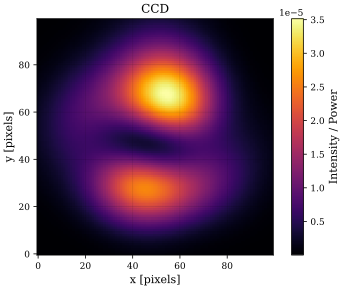

In [11]:
### This comes in handy later. One can also
### plot a single beam image at a given ETM.phi,
### selected by its index in the array.

plot_ccd(images['ccd_tra'][75], zmax=None, zmin=None);

## Exploring cavities with different model parameters

Until now, we have modeled an ideal cavity and studied the mode discrimination capabilities of the cavity.

**Task**: We would like you to experiment with different geometries and characteristics of the cavity. Some of the parameters that you can change are the radius of curvature (RoC) of the mirrors, the inter-cavity length, and the transmissivity or reflectivity of the mirrors. What we would like you to do is to perform FSR scans of your “experimental” cavity and explain the key differences you observe in the FSR scans of your cavity compared to those of the ideal LIGO cavity. 

For each modification, clearly describe:

- Which parameter(s) you changed, and by how much  
- Why you chose to change those parameter(s)  
- The key differences you observe in the FSR scans compared to the ideal LIGO cavity  
- The physics consequences of changing that parameter  
  (for example: changes in stability, mode spacing, linewidth, resonance contrast, or higher-order mode behavior)

To give an example of how one can quickly model and simulate these changes, a demonstration is shown below.

In [12]:
## Example to build your own model and change model parameters
## --------------------------------------------------------------

# Copy the mode-matched model defined earlier,
# with a few detectors already included in the model
exp1 = fsr.deepcopy() 

# Make changes to the model
# Here we are changing the transmissivity of the ETM
# One can call the name of the component and the
# parameter you would like to change

exp1.ETM.T = 0.1e-1
# ETM is the name of the component and
# T is the parameter of the component we are changing

# Check
print("Transmissivity of ETM of our ideal model:", matched.ETM.T)
print("Transmissivity of ETM of our current model:", exp1.ETM.T)

## Note: The transmissivity (T), reflectivity (R), and losses (L) are interlinked.
## If you change one, the undefined parameter in your model changes.
## The relation is such that R + T + L = 1. So please keep in mind
## the legal values these parameters can take.


Transmissivity of ETM of our ideal model: 7.1e-06
Transmissivity of ETM of our current model: 0.01


## Effect of defects on optical cavities
#### Moving away from perfect optical systems

From here on, we will try to model more realistic optical cavities, i.e., cavities with defects. The main takeaway from these simulations should be to understand what happens when such mismatches exist in the system. We will consider two kinds of defects:

1. **Misalignment of the input beam to the cavity:**  
   This leads to scattering of light from the fundamental mode into HOMs (for example HG<sub>10</sub>, HG<sub>20</sub>, HG<sub>30</sub>).

2. **Mode mismatch:**  
   We will change the input beam parameters and create a mismatch between the input beam and the cavity eigenmode. Mode mismatches of this kind lead to scattering of light into even-order modes (for example HG<sub>20</sub>, HG<sub>40</sub>, HG<sub>22</sub>, etc.).

Again, using FSR scans, we will try to understand the nature of these cavities and the extent of mismatches that exist in the system. We will also make use of other detectors in FINESSE to study the scattering of power into higher-order modes (HOMs) in more detail.

### Model with steering mirrors

To create misalignments of the input beam to the cavity, we will make use of a steering mirror (SM). We will add this to our *cavLIGO* model defined in the section above. By tip tilting the mirror (in x or y) we can steer the input beam to the cavity such that the beam axis and the optical axis of the cavity is not perfectly superposed (aligned). We will make use of the **Beam Splitter** element in FINESSE to model this SM. The reflectivity of the BS element is set to 1, which means it reflects 100% of the light impinging on it. It can be thought of as an perfectly reflective mirror. 

In [13]:
## Modeling an ideal cavity in FINESSE with steering mirrors
## -----------------------------------------------------------

# Geometry of our cavities
L = 3994.485 # cavity length in meters 
rocITM = -1937.9 # RoC of the input test mass/mirror
rocETM = 2240.0 # RoC of the end test mass mass

# Building an optical cavity model in Finesse 
cavSTM = finesse.Model()
cavSTM.modes(maxtem=8) #setting mode orders

# Defining the optics
cavSTM.parse(
f"""
# Input optics          
l l1 P=1 #laser with 1W power
s s1 l1.p1 stm.p1 L=1 #space between laser and input test mass

# steering mirror to create misalignment
bs stm R=1 T=0 alpha=-45 #using a perfectly reflecting BS element
s s_stm stm.p2 ITM.p1 L=0.5

# Input test mass/mirror of the cavity
# T and L are the transmittivity and losses in the mirror
# and R (reflectivity) is computed as R=1-T-L. 
m ITM T=0.0148 L=37.5e-6 Rc={rocITM} #mirror
           
# Space between the two test masses 
s s2 ITM.p2 ETM.p1 L={L} #defined in the geometry

# End test mass 
m ETM T=7.1e-6 L=37.5e-6 Rc={rocETM} #mirror

# cav (for mode-matching)
cav arms ETM.p1.o ITM.p2.i 
""");

# checking mismatches
cavSTM.run()
print(cavSTM.mismatches_table())

┌──────────╥──────────────┬──────────────┐
│ Coupling ║ Mismatch (x) │ Mismatch (y) │
└──────────╨──────────────┴──────────────┘



### Misaligned Optics

In [14]:
## Scattering into HOMs due to misalignments in the optical system.
## ------------------------------------------------------------------

# copying the SM mode matched model
mismat1 = cavSTM.deepcopy()
mismat1.modes(maxtem=4) #defining the maximum order of transverse modes (HOMs)

# Adding detectors to study the basic properties
mismat1.parse(
    f"""
    # power detectors to measure the total power
    # circulating, transmitted, and reflected of the cavity
    pd refl ITM.p1.o
    pd trans ETM.p2.o
    pd circ ETM.p1.i

    # amplitude detectors for different HOMs
    # to study modes inside the cavity
    ad ad00 ETM.p1.i l1.f n=0 m=0
    ad ad01 ETM.p1.i l1.f n=0 m=1
    ad ad10 ETM.p1.i l1.f n=1 m=0
    ad ad11 ETM.p1.i l1.f n=1 m=1
    ad ad20 ETM.p1.i l1.f n=2 m=0
    ad ad02 ETM.p1.i l1.f n=0 m=2
    ad ad30 ETM.p1.i l1.f n=3 m=0
"""
)

#misaligning the end test mirror by 0.6 mirco radian in x
mismat1.stm.xbeta = 0.6e-6 
mismat1.run()

## FSR scans of the cavity (changing the ETM.phi)
scan2 = mismat1.run(Xaxis('ETM.phi', 'lin', -200, 200, 500))

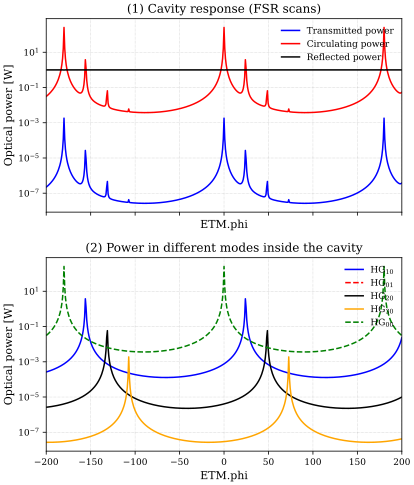

In [15]:
# Plots
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(6, 7),
)

ax = axes[0]
ax.plot(scan2.x[0], scan2["trans"], label="Transmitted power")
ax.plot(scan2.x[0], scan2["circ"],  label="Circulating power")
ax.plot(scan2.x[0], scan2["refl"],  label="Reflected power")
ax.set_yscale("log")
ax.set_xlabel(r"ETM.phi")
ax.set_ylabel("Optical power [W]")
ax.set_title("(1) Cavity response (FSR scans)")
ax.legend(frameon=False)
ax.grid(True, which="both", linestyle=":", linewidth=0.5)

ax = axes[1]
ax.plot(scan2.x[0], np.abs(scan2["ad10"])**2, label=r"HG$_{10}$")
ax.plot(scan2.x[0], np.abs(scan2["ad01"])**2, label=r"HG$_{01}$", linestyle='--')
ax.plot(scan2.x[0], np.abs(scan2["ad20"])**2, label=r"HG$_{20}$")
ax.plot(scan2.x[0], np.abs(scan2["ad30"])**2, label=r"HG$_{30}$")
ax.plot(scan2.x[0], np.abs(scan2["ad00"])**2, linestyle="--",label=r"HG$_{00}$")
ax.set_yscale("log")
ax.set_xlabel(r"ETM.phi")
ax.set_ylabel("Optical power [W]")
ax.set_title("(2) Power in different modes inside the cavity")
ax.legend(frameon=False)
ax.grid(True, which="both", linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

In these scans, we can see that the first-, second-, and third-order transverse modes are now excited in the cavities. These modes are generated by the misalignment between the input beam and the cavity axis. They are enhanced at specific values of the tuning parameter (ETM.phi). For example, the resonance of the HG<sub>01</sub> mode is observed at around ETM.phi = 25 deg. That the resonance length for the HG mode is different comes from the extra Gouy phase the HG<sub>01</sub> mode experiences along propagation.

In practice, we usually operate the cavity in a condition (here at phi=0), where HOMs are strongly suppressed by the cavity and predominantly only the fundamental mode resonates inside it.

Comparing with the beam images shown earlier, light that does not couple into the cavity (i.e., does not resonate) is reflected from the cavity. Of course, those reflected images do not contain just a single HOM, but rather a superposition of all the modes that are not supported (or not resonant) in the cavity.

**Task**: In this example, the cavity is misaligned in the *x* direction. By examining the resulting plots, can you develop an intuitive understanding of which optical modes would resonate if the cavity were misaligned in the *y* direction? Justify your answer through plots or logic. 

### Mode mismatches

A mode-mismatched cavity refers to a situation in which the spatial profile of the input light beam (for example, its size or wavefront curvature) does not perfectly match the natural electromagnetic field pattern (the eigenmode) of the optical resonator. This leads to inefficient coupling of light into the cavity, excitation of higher-order modes, and in turn a reduction in signal quality, which in turn impacts our GW measurements.

To create mode mismatch in FINESSE, we now need to explicitly define the input beam. This essentially fixes the complex beam parameter q at a specified node in the model. We will do this using the **Gauss** command. We will define the q-parameter of the input beam at the output of our laser node using the completely mode-matched model as a reference.

In [16]:
## Cavity model with fixed input beam (Ideal case)
## -------------------------------------------------
# copying the mode matched model
mm = matched.deepcopy()
mm.modes(maxtem=2) #defining the maximum order of transverse modes allowed in the model (HOMs)

# extracting beam parameters from the matched model (at the laser output)
w0 = matched.l1.p1.o.qx.w0 #waist size
z = matched.l1.p1.o.qx.z # distance to the waist

# Fixing the input beam using Gauss
mm.parse(f"gauss inputbeam l1.p1.o w0={w0} z={z}")

# Adding detectors to study the properties
mm.parse(
    f"""
    # power detectors to measure the total power
    # circulating, transmitted, and reflected of the cavity
    pd refl ITM.p1.o
    pd trans ETM.p2.o
    pd circ ETM.p1.i

    # amplitude detectors for different HOMs
    ad ad00 ETM.p1.i l1.f n=0 m=0
    ad ad01 ETM.p1.i l1.f n=0 m=1
    ad ad10 ETM.p1.i l1.f n=1 m=0
    ad ad02 ETM.p1.i l1.f n=0 m=2
    ad ad20 ETM.p1.i l1.f n=2 m=0
"""
)

# Runs and checking mismatches
mm.run()
print(mm.mismatches_table()) #checking mismatches

# FSR scans (ideal case --> no mismatch)
scanmm = mm.run(Xaxis('ETM.phi', 'lin', -200, 200, 200))

┌──────────╥──────────────┬──────────────┐
│ Coupling ║ Mismatch (x) │ Mismatch (y) │
└──────────╨──────────────┴──────────────┘



#### Creating mismatches in the input beam

In this exercise we will create mode mismatches in the system by changing the input beam parameters which is defined at the laser output node. As an example here we change the waist size of the input beam by 5%. By doing this we now create a mode mismatch between the cavity eigenmode and the input beam. The mismatch will occur at the input test mass interface. Again, the result of this mismatch will be scattering of light into HOMs.

In [17]:
# Creating mode mismatches by changing the input beam parameters
# ----------------------------------------------------------------

# copying the model defined above 
# with fixed input beam
mm_ib = mm.deepcopy()
mm_ib.run()

# Changing the size of the waist of the input beam by 5%
mm_ib.l1.p1.o.qx.w0 = 1.05*w0 #w0 is the ideal beam size for mode matched case

# printing mismatches
print(mm_ib.mismatches_table())

# FSR scans (with mismatch)
scanib = mm_ib.run(Xaxis('ETM.phi', 'lin', -200, 200, 200))

┌──────────────────────╥──────────────┬──────────────┐
│       Coupling       ║ Mismatch (x) │ Mismatch (y) │
╞══════════════════════╬══════════════╪══════════════╡
│ ITM.p1.i -> ITM.p2.o ║       0.0024 │       0.0024 │
├──────────────────────╫──────────────┼──────────────┤
│ ITM.p1.i -> ITM.p1.o ║       0.0018 │       0.0018 │
├──────────────────────╫──────────────┼──────────────┤
│ ITM.p2.i -> ITM.p1.o ║       0.0024 │       0.0024 │
└──────────────────────╨──────────────┴──────────────┘



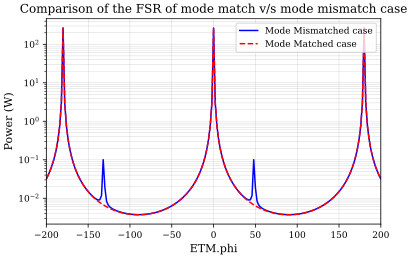

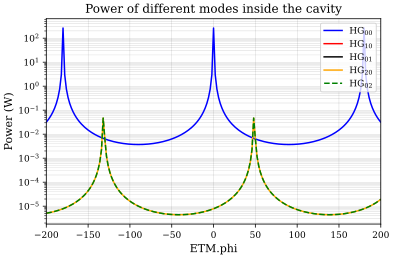

In [18]:
## Plots: mode matched v/s mode mismatched case
plt.plot(scanib.x[0], scanib['circ'], label="Mode Mismatched case")
plt.plot(scanmm.x[0], scanmm['circ'], label="Mode Matched case", linestyle='--')
plt.legend()
plt.yscale('log')
plt.xlabel("ETM.phi")
plt.ylabel("Power (W)")
plt.title("Comparison of the FSR of mode match v/s mode mismatch case")
plt.show()

# Plotting other HOMs from the scans
plt.plot(scanib.x[0], np.abs(scanib["ad00"])**2, label=r"HG$_{00}$")
plt.plot(scanib.x[0], np.abs(scanib["ad10"])**2, label=r"HG$_{10}$")
plt.plot(scanib.x[0], np.abs(scanib["ad01"])**2, label=r"HG$_{01}$")
plt.plot(scanib.x[0], np.abs(scanib["ad20"])**2, label=r"HG$_{20}$")
plt.plot(scanib.x[0], np.abs(scanib["ad02"])**2, label=r"HG$_{02}$", linestyle='--')
plt.xlabel("ETM.phi")
plt.ylabel("Power (W)")
plt.yscale('log')
plt.title("Power of different modes inside the cavity")
plt.legend()
plt.show()

**Task**: In our example of mode mismatch we changed the input beam parameters defined at the laser output. Can you think of other ways mode mismatches can occur in such systems? *Hint: So now we have two beam defined in the model - the input beam and the cavity (eigenmode). Think of ways how we can change the cavity eigenmode and keep the input beam fixed.*  

From these scans, we can see that second-order transverse modes are excited due to the mode mismatch present in the optical system. In this example, we introduced a mismatch of about 0.24% by changing the waist size of the input beam by 5% at the laser input. This static mismatch leads to a scattering of light from the fundamental mode into HOMs (in this case, even-order modes). In optical systems, this effect is commonly referred to as loss. Such losses have adverse effects on several aspects of GW detectors, in particular on the sensitivity with which GWs can be measured.

In future gravitational-wave detectors, which aim for even higher sensitivity, it will be crucial to minimize these losses. Ideally, we would like 100% of the optical power to remain in the fundamental mode. Achieving this requires improved mode-matching systems and/or complementary diagnostics to measure and correct any mode mismatch present in the optical system.

## Visualising the mode discriminating effects of a cavity

**Task**: In this task, you will visualise the 2D (CCD camera) beam profiles at the input and at the output (transmission) of the cavity. This will be done for the case of a misaligned input beam, as discussed earlier. By plotting and comparing these images, you will investigate and describe the physical differences between the input and transmitted fields.

Specifically, you are asked to:
1. For the model given below, add CCD detectors at the appropriate ports in order to record the beam profiles at the input and at the transmitted cavity ports.
2. Using the *plot_ccd()* helper function, plot the corresponding beam images.
3. Describe and discuss the physics illustrated by these images. In particular, you should clearly explain the fundamental physical differences between the input and output beam profiles, and relate these differences to the effect of cavity spatial filtering, and HOMs resonances.

In [19]:
# Task 2 optical cavity model
# ------------------------------------------

## copying the mismatched model
task2 = mismat1.deepcopy()

## changing the alignment of the steering 
## mirror thereby changing the alignment of
## the input beam to the cavity
task2.stm.xbeta = 5e-6 

# Your task
# --------------------------------------


## Why do we need cavities?

Optical cavities can be thought of as filters. They can filter out unwanted frequencies of light and spatial modes (higher-order modes, HOMs) that may be present due to imperfections in the optical system. This statement is true, but incomplete: the effectiveness of this filtering depends on how selective or precise we want the filtering to be. In this final section, we briefly discuss the filtering capabilities of optical cavities. In particular, we address the question: when is a cavity a good filter, and when is it not? Furthermore, in the presence of imperfections, what should guide our design choices?

In this example, we do not scan the microscopic tuning of the end test mass (ETM.phi), since that is not our goal here. Instead, we are interested in changing another parameter of the cavity that is not related to its length, but rather to an intrinsic property of the cavity: its finesse. We change the finesse of the cavity by scanning the transmissivity \(T\) of the input test mass (ITM). Increasing \(T\) leads to a lower finesse, as these two quantities are inversely related.

It is important to note that all these scans are performed at a fixed tuning of the cavity (ETM.phi = 0), and the cavity is designed such that the fundamental mode is resonant at this particular tuning of the end test mass.


In [20]:
## Changing the characteristics of the cavity
## ----------------------------------------------------------------
# making a copy of the SM model 
tscans = cavSTM.deepcopy()
tscans.modes(maxtem=5) #defining the maximum order of transverse modes (HOMs)

# Adding detectors to study the basic properties
tscans.parse(
    f"""
    # power detectors to measure the total power
    # circulating, transmitted, and reflected of the cavity
    pd refl ITM.p1.o
    pd trans ETM.p2.o
    pd circ ETM.p1.i

    # cavity property detector 
    # for computing the finesse of the cavity
    cp fin arms finesse

    # amplitude detectors for different HOMs
    ad ad00 ETM.p1.i l1.f n=0 m=0
    ad ad01 ETM.p1.i l1.f n=0 m=1
    ad ad10 ETM.p1.i l1.f n=1 m=0
    ad ad02 ETM.p1.i l1.f n=0 m=2
    ad ad20 ETM.p1.i l1.f n=2 m=0
    ad ad30 ETM.p1.i l1.f n=3 m=0
"""
)

#misaligning the end test mirror
tscans.stm.xbeta = 0.6e-6 
tscans.run()

## Scanning the transmission of the cavity
## By doing this we are degrading the Finesse of 
## the cavity and correspondingly broadening the linewidth 
## and reducing the storage time of light inside the cavities.
scan_t = tscans.run(Xaxis('ITM.T', 'lin', tscans.ITM.T, 0.8, 200))

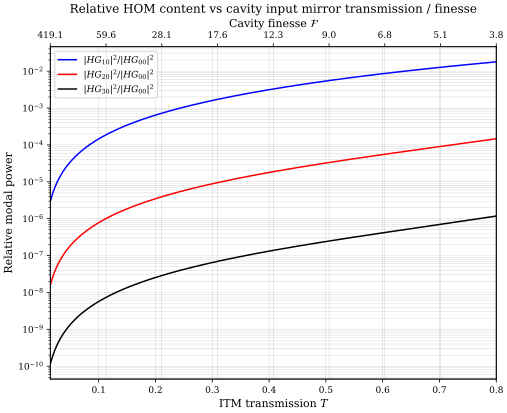

In [21]:
# Plots for the normalised HOM power 
# resonating inside the cavity for different T

ratio_10 = np.abs(scan_t['ad10'])**2 / np.abs(scan_t['ad00'])**2
ratio_20 = np.abs(scan_t['ad20'])**2 / np.abs(scan_t['ad00'])**2
ratio_30 = np.abs(scan_t['ad30'])**2 / np.abs(scan_t['ad00'])**2

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(scan_t.x[0], ratio_10, label=r"$|HG_{10}|^2 / |HG_{00}|^2$")
ax.plot(scan_t.x[0], ratio_20, label=r"$|HG_{20}|^2 / |HG_{00}|^2$")
ax.plot(scan_t.x[0], ratio_30, label=r"$|HG_{30}|^2 / |HG_{00}|^2$")
ax.set_yscale("log")
ax.set_xlabel(r"ITM transmission $T$")
ax.set_ylabel(r"Relative modal power")
ax.set_title("Relative HOM content vs cavity input mirror transmission / finesse")
ax.grid(True, which="both", alpha=0.3)
ax.legend()

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
T_ticks = ax.get_xticks()
F_ticks = np.interp(T_ticks, scan_t.x[0], scan_t['fin'])
ax2.set_xticks(T_ticks)
ax2.set_xticklabels([f"{f:.1f}" for f in F_ticks])
ax2.set_xlabel(r"Cavity finesse $\mathcal{F}$")
plt.show()


**Task**: As an experimentalist you are given to design the arms of the Einstein Telescope. The cavities of current GW detectors are about 450. What would be your choice of finesse for the arm cavities of ET? Justify your answer. 

All HOMs increase in power relative to the fundamental mode as the transmissivity \(T\) of the ITM is increased and, consequently, the finesse of the cavity is reduced, as shown in the plot above. This is not a coincidence, at the chosen working point, the relative power in all these modes increases systematically as the cavity becomes less selective. In other words, the efficiency with which the cavity filters spatial modes is reduced as the finesse of the cavity decreases.

## Suggestions and other comments

1. These notebooks act as your “experiments.” Feel free to play around with different detectors, components, and different imperfections. 

2. Please use the FINESSE documentation page to search for anything that you might be interested in reading about and applying to this notebook (https://finesse.ifosim.org/docs/latest/index.html). 

3. Try copying and pasting these models into different cells and let your imagination/curiosity run wild. Try changing the parameters of your model and understand the consequences of it by plotting different detectors. The main gist of this exercise is to develop an understanding of the concepts and to be able to explain the plots and the results that you see.